# Cart and Inverted Pendulum Simulation

- This is a Julia version of the system used in my Open AI Gym environment:
https://github.com/billtubbs/gym-CartPole-bt-v0/
- Both mimic the system used in Steve Brunton's Control Bootcamp video lecture series.

In [1]:
include("CartPoleBTEnv.jl")

Main.CartPoleBTEnv

In [2]:
using Printf
using Test
using Plots
using .CartPoleBTEnv

In [3]:
# Prepare directories
#plot_dir = "plots"
#data_dir = "data"

#for dir_path in [plot_dir, data_dir]
#    if ~isdir(dir_path)
#        mkdir(dir_path)
#    end
#end

In [4]:
methods(CartPole)

# 1 method for generic function "(::Type)":
[1] CartPole(; description, goal_state, initial_state, disturbances, initial_state_variance, measurement_error, hidden_states, n_steps) in Main.CartPoleBTEnv at /Users/billtubbs/cartpole/CartPoleBTEnv.jl:78

In [5]:
gym = CartPole()
gym.description

"Cart-pendulum system"

In [6]:
methods(step)

# 8 methods for generic function "step":
[1] step(gym::CartPole, u::Float64) in Main.CartPoleBTEnv at /Users/billtubbs/cartpole/CartPoleBTEnv.jl:131
[2] step(S::BandedMatrices.BandSlice) in BandedMatrices at /Users/billtubbs/.julia/packages/BandedMatrices/vcLoH/src/generic/Band.jl:193
[3] step(r::StepRange) in Base at range.jl:498
[4] step(r::AbstractUnitRange{T}) where T in Base at range.jl:499
[5] step(r::StepRangeLen{T,R,S} where S where R) where T in Base at range.jl:500
[6] step(r::LinRange) in Base at range.jl:501
[7] step(a::OffsetArrays.OffsetArray{T,1,#s12} where #s12<:AbstractRange{T} where T) in OffsetArrays at /Users/billtubbs/.julia/packages/OffsetArrays/Z45he/src/OffsetArrays.jl:183
[8] step(gym::CartPole, u::Array) in Main.CartPoleBTEnv at /Users/billtubbs/cartpole/CartPoleBTEnv.jl:179

For an introduction to how functions and methods work in Julia (multiple dispatch) see:
- [Think Julia, Chapter 7](https://benlauwens.github.io/ThinkJulia.jl/latest/book.html#chap17)

## Run simulation

In [7]:
gym = CartPole(initial_state_variance="high", disturbances="none")
n_steps = gym.n_steps
state_record = zeros(n_steps,4)
rewards = zeros(n_steps)
reset(gym)
done = false
while ~done
    u = 0.0  # Input
    state, reward, done = step(gym, u)
    i = gym.time_step
    state_record[i, :] = state
    rewards[i] = reward
end

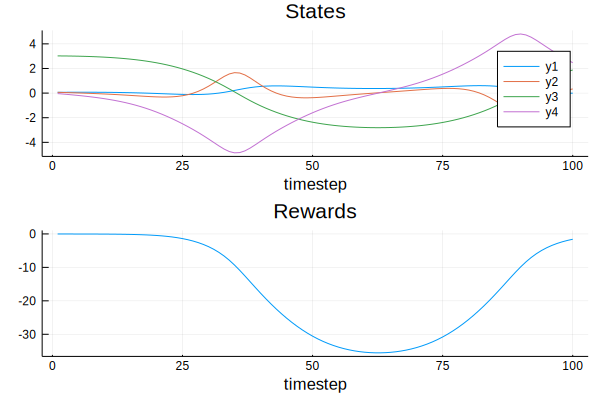

In [8]:
p1 = plot(1:n_steps, state_record, xlabel="timestep", title="States")
p2 = plot(1:n_steps, rewards, xlabel="timestep", title="Rewards", legend = false)
plot(p1, p2, layout = (2, 1))

In [9]:
function random_policy(env::CartPole, state::Array)
    u_min, u_max = env.action_space
    return rand() * (u_max - u_min) + u_min
end


function rollout(env::CartPole, policy)
    reset(env)
    n_steps = env.n_steps
    state_record = zeros(n_steps,4)
    rewards = zeros(n_steps)
    done = false
    while ~done
        action = policy(env, env.state)
        state, reward, done = step(gym, action)
        i = gym.time_step
        state_record[i, :] = state
        rewards[i] = reward
    end
    return state_record, rewards
end


function rollout(env::CartPole, policy, n_repeats::Int)
    n_steps = env.n_steps
    cum_rewards = zeros(n_steps)
    for i in 1:n_repeats
        state_record, rewards = rollout(env, policy)
        cum_rewards[i] = sum(rewards)
    end
    return cum_rewards
end;

## Speed tests

In [10]:
gym = CartPole(initial_state_variance="high", disturbances="low")
println("Timings per episode:")
for i in 1:5
    @time state_record, rewards = rollout(gym, random_policy);
end
n_episodes = 100
@printf("\nTimings for %d episodes:\n", n_episodes)
@time cum_rewards = rollout(gym, random_policy, n_episodes);

Timings per episode:
  0.044408 seconds (80.05 k allocations: 5.961 MiB, 19.34% gc time)
  0.017257 seconds (68.52 k allocations: 5.339 MiB)
  0.020948 seconds (67.47 k allocations: 5.253 MiB)
  0.017058 seconds (66.53 k allocations: 5.177 MiB)
  0.028342 seconds (67.59 k allocations: 5.263 MiB, 29.60% gc time)

Timings for 100 episodes:
  1.933099 seconds (6.92 M allocations: 535.744 MiB, 6.94% gc time)


In [11]:
# With Euler approximation (y = y + tau * y_dot)
gym = CartPole(initial_state_variance="high", disturbances="low")
gym.kinematics_integrator = "euler"
println("Timings per episode:")
for i in 1:5
    @time state_record, rewards = rollout(gym, random_policy);
end
n_episodes = 100
@printf("\nTimings for %d episodes:\n", n_episodes)
@time cum_rewards = rollout(gym, random_policy, n_episodes);

Timings per episode:
  0.000634 seconds (3.71 k allocations: 106.313 KiB)
  0.000561 seconds (3.71 k allocations: 106.313 KiB)
  0.000562 seconds (3.71 k allocations: 106.313 KiB)
  0.000555 seconds (3.71 k allocations: 106.313 KiB)
  0.007134 seconds (3.71 k allocations: 106.313 KiB, 90.92% gc time)

Timings for 100 episodes:
  0.057768 seconds (371.11 k allocations: 10.383 MiB)
